# Data processing from Grasshopper to Python

In [1]:
import numpy as np
import string
import matplotlib.pyplot as plt
import sklearn
from scipy.spatial.transform import Rotation as R

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Layout
from IPython.display import display

import copy

#%matplotlib inline

### Load/Process/Save Data

In [2]:
class stroke_processor(object):
    def __init__(self,
                 max_padded_length = None,
                 scans_path = None,
                 motion_path_folder = None,
                files_to_read = None):
        """
        This class loads motions and undersample them to make it easier to process them.
        """
        if scans_path is None:
            self.scans_path = "../processed_data/numpy data/brush_strokes_128x256.npy"
            
        if motion_path_folder is None:
            self.motion_path_folder = "../processed_data/numpy data/"
        if max_padded_length is None:
            self.max_padded_length = 60
        if files_to_read is None:
            self.files_to_read = 44
        
        self.motions_raw, self.sizes, self.all_motions_as_list = self.load_motions()
    
    
    
    def convert_pages_to_np_data(self,data_of_one_page,max_padded_length = 50, safety_padding_size = 500 ):
        """
        input: data for one page of scans in the format of string 
        output: a numpy array of size axbx4x4 where:
                    a is the number of stroke in that page
                    b is a hyper parameter for padding size 
        """

        # some basic cleanups
        data_of_one_page = "".join(data_of_one_page)
        data_of_one_page = data_of_one_page.replace('\n', ',')
        motions = data_of_one_page.split("&")

        # finding how many motions are in this file
        sample_size = len(motions)

        # making the plcaeholder for all motions in this file
        all_motion_matrices = np.zeros(shape=(sample_size+1,max_padded_length,4,4))


        ### MOTION LOOP ###
        for i in range (1,sample_size):
            # this loop goes over 20 strokes in one page
            motion = motions[i]
            steps = motion.split("|")

            # resetting the matrice for one motion
            one_motion_matrices = []

            ### MATRIX LOOP ###
            for step in steps:
                # this loop goes over 120+ matrices in one stroke
                matrices = step.split(",")
                matrices.remove("")
                if len(matrices) > 5 :
                    # the last value is also an empty string that should be removed
                    matrices.pop()

                    matrices = np.array([float(val) for val in matrices]).reshape(1,4,4)

                    one_motion_matrices.append(matrices)
            #print (len(one_motion_matrices))


            ### Padding or Under sampling
            if len(one_motion_matrices) > max_padded_length:
                #print ("long: {}".format(len(one_motion_matrices)))
                one_motion_matrices = self.under_sampler(one_motion_matrices,max_padded_length)
                #print ("reduced to {}".format(len(one_motion_matrices)))

            # now we need to correct the padding:
            padded_one_motion_matrices = np.zeros(shape = (1,max_padded_length,4,4))

            for j in range(len(one_motion_matrices)):
                padded_one_motion_matrices[:,j,:,:] = one_motion_matrices[j]

            # assembling all motions of a page into one np array!
            all_motion_matrices[i,:,:,:] = padded_one_motion_matrices

        return all_motion_matrices[1:-1,:,:,:]

    def under_sampler(self,data, max_size):
        """
        converts a data of n samples to max_size samples.
        """
        indices = np.random.choice(list(range(len(data))), max_size, replace= False)
        indices = list(indices)
        indices.sort()
        under_samples = [data[i] for i in indices]
        return under_samples

    def load_motions(self,
                     path= None,  
                     max_padded_length = None,
                     files_to_read = None):
        """
        Loads all the motions from a given folder
        """
        if path is None:
            path = self.motion_path_folder
        if max_padded_length is None:
            max_padded_length = self.max_padded_length
        if files_to_read is None:
            files_to_read = self.files_to_read
            
        self.all_motions_as_list = []
        place_holder = np.zeros(shape=(1,max_padded_length,4,4))  
        sizes = []
        for i in range(1,files_to_read+1):
            if i < 10:
                index = "0" + str(i)
            else:
                index = str(i)

            file_name = path+str(index)+".txt"

            data = open(file_name, 'r')
            motion_values = [m for m in data]
            motion_data_as_array = self.convert_pages_to_np_data(motion_values,max_padded_length)
            sizes.append(motion_data_as_array.shape[0])
            #print (i, motion_data_as_array.shape)

            # for some reason, it doesn't handle the first item in the list!! WHY?!
            if i >0:
                place_holder = np.append(place_holder,motion_data_as_array,axis= 0 )
            self.all_motions_as_list.append(motion_data_as_array)

        np.save(self.motion_path_folder+"motion_data",place_holder[1:])
        return place_holder[1:], sizes, self.all_motions_as_list

# Processing the transformation matrices 
Basically the matrix is 4x4: <br>
* the top 3x3 section is the rotation;<br>
* the right 1x3 is translation;<br>
* the lower row is just scale! Skip it.<br>

We grab the rotation and convert it into Euler, then add the translation! That is easy

In [3]:
def convert_matrix_to_concatenated(motion_data, only_on_page = False):
    """
    Inputs:
        Collects a data structure of axbx4x4:
            a: the number of motions
            b: the number of steps in the motion (all the motions MUST HAVE THE SAME b VALUE)
            4x4: the transformation matrix from Grasshopper
    Outputs:
        an array of shape axbx6
        the 6 numbser are: 
            1-3: euler_rotation (xyz, in radians)
            4-6: tran_matrix in mm    
    """
    
    # making a copy of data to take care of pointers, not necessary at all!
    sample_data = motion_data[:,:,:,:]
    # changing the shape to make it easier to process them in one go!
    
    if (only_on_page):
        sample_data = sample_data.reshape(motion_data.shape[0]*motion_data.shape[1],4,4)
    else:
        sample_data = sample_data.reshape(motion_data.shape[0]*motion_data.shape[1],4,4)

    # extracting rotation and translation matrices
    rot_matrix= sample_data[:,:3,:3]
    tran_matrix = sample_data[:,:3,3]
    
    # processing the rotation matrix
    rotation = R.from_matrix(rot_matrix)
    euler_rotation = rotation.as_euler('xyz')#, degrees=True)
    
    # assembling
    concatenated_data = np.append(euler_rotation, tran_matrix, axis= 1)

    # handling the shape
    if (only_on_page):
        print ("one page")
        concatenated_data = concatenated_data.reshape(motion_data.shape[0],motion_data.shape[1],6)
    else:
        concatenated_data = concatenated_data.reshape(motion_data.shape[0],motion_data.shape[1],6)


    return concatenated_data


In [7]:
class scanned_pages_reader(object):
    def __init__(self, scanned_path = None, number_of_pages = None):
        if scanned_path == None:
            self.scanned_path= "../processed_data/numpy data/"
            #"../03-Raw data, scans and motions from Grasshopper/Stroke scan processing/"
        else:
            self.scanned_path = scanned_path
        if number_of_pages == None:
            self.number_of_pages = 45
        else:
            self.number_of_pages = number_of_pages

        self.create_file_names()
        self.read_all_pages()
        
    def create_file_names(self):
        self.file_names = []
        for i in range (1,self.number_of_pages):
            if i < 10:
                tag = "0"+str(i)
            else:
                tag = str(i)
            self.file_names.append(self.scanned_path+tag+".npy")

    def read_one_page(self,page_name = 1):
        page_index = page_name -1
        page_data = np.load(self.file_names[page_index])
        print (page_data.shape)
        for i in range (page_data.shape[0]):
            plt.imshow(page_data[i])
            plt.show()

    def read_all_pages(self):
        self.all_pages_data = []
        for name in self.file_names:
            page_data = np.load(name)
            self.all_pages_data.append(page_data)
        return self.all_pages_data

In [13]:
class dataset_creator(object):
    def __init__(self, missing_items = None):
        if missing_items is None:
            # all the missing items from various pages will be recorded 
            # in this dictionary.
            self.missing_items = {1:[17],
                                 2:[12,13],  
                                 18:[12, 17],
                                 19:[16],
                                 21:[9],
                                 25:[0],
                                 26:[0,2,3,4,5,6,12],
                                 27:[8,9],
                                 29:[4],
                                 30:[16],
                                 37:[8],
                                 38:[4,7],
                                 40:[13],
                                 42:[10]}
        else:
            self.missing_items = missing_items
        self.gradient = False
        self.scanned_pages = scanned_pages_reader()
        self.stroke_processor_instance = stroke_processor()
        self.all_scanned_pages_as_list = self.scanned_pages.all_pages_data
        self.all_motions_as_list = self.stroke_processor_instance.all_motions_as_list
        self.post_process_and_save()
    
    def plot_page_checker(self,motions, strokes, index):
        """
        Collects a motion and a stroke and plots them next to each other!
        """
        # this plit trick is from here: https://gist.github.com/decvalts/5154e6562ff12276ffe561c213b071b9
        plot_size = motions.shape[0]
        print (plot_size)
        print (motions.shape)
        minmax  = [-25, 25]

        
        motion = motions
        motion_x = motion[:,:,3]
        motion_y = motion[:,:,4]
        motion_z = motion[:,:,5]

        stroke = strokes
        number_of_rows = (plot_size//4)+ 1

        fig, axes = plt.subplots(number_of_rows, 8, figsize=(8,4))#,  dpi=250)
        fig.suptitle('Page number: {}'.format(index), fontsize=6, fontweight='normal')


        for j in range(number_of_rows):
            for i in range (4):
                ax1 = axes[j][2*i]
                ax1.set_xlabel('x')
                ax1.set_ylabel('y')
                # Set each axis limits
                ax1.set_xlim(minmax)
                ax1.set_ylim(minmax) 
                # Equally stretch all axes
                ax1.set_aspect("equal")
                ax1.axis("off")
                ax2 = axes[j][2*i+1]
                ax2.axis("off")

                if j*4+i < plot_size :
                    if self.gradient:
                        npts=motion_y.shape[1]
                        X = -motion_y[j*4+i,:]
                        Xs = X[:-1]
                        Xf = X[1:]
                        Xpairs = zip(Xs, Xf)
                        Y = motion_x[j*4+i,:]
                        Ys = Y[:-1]
                        Yf = Y[1:]
                        Ypairs = zip(Ys, Yf)
                        C = np.linspace(0,1, npts)
                        cmap = plt.get_cmap()
                        # the simplest way of doing this is to just do the following:
                        for x, y, c in zip(Xpairs, Ypairs, C):
                            ax1.plot(x, y, '-', c=cmap(c),linewidth=1)
                    
                    else:
                        ax1.plot(-motion_y[j*4+i,:],motion_x[j*4+i,:],linewidth=1)
                    ax2.imshow(stroke[j*4+i,:],cmap='gray')

    def check_that_page(self, index, missing_items = None):
        if missing_items is None:
            missing_items = {}

        page_data = self.all_scanned_pages_as_list [index]
        if index in missing_items:
            page_data = np.delete(page_data,missing_items[index],axis = 0)
        motion_data =self.all_motions_as_list[index]
        motion_data = convert_matrix_to_concatenated(motion_data, True)
        self.plot_page_checker(motion_data, page_data, index)

    
    def interactive_plot (self, gradient = False):
        self.gradient = gradient
        _ = interact (self.check_that_page, 
                      index = widgets.IntSlider(min = 0,max = 43,step= 1,
                                                description="Page number", 
                                                layout= Layout(width="100%")),
                      missing_items= fixed(self.missing_items))

    def post_process_and_save(self):
        self.all_available_strokes = []
        for i in range (len(self.all_scanned_pages_as_list)):
            page_data = self.all_scanned_pages_as_list [i]
            if i in self.missing_items:
                page_data = np.delete(page_data,self.missing_items[i],axis = 0)
            self.all_available_strokes.append(page_data)
        
        self.X_stroeks = np.zeros(shape=(1,128,256))
        self.Y_motions = np.zeros(shape= (1,60,4,4))
        for i in range (len(self.all_scanned_pages_as_list)):
            self.X_stroeks = np.append(self.X_stroeks,self.all_available_strokes[i], axis = 0)
            self.Y_motions = np.append(self.Y_motions, self.all_motions_as_list[i], axis = 0)
        self.Y_motions = convert_matrix_to_concatenated(self.Y_motions)
        
        print ("Stroeks' shape: ", self.X_stroeks.shape)
        print ("Motions' shape: ", self.Y_motions.shape)
        
        np.save("motions_{}".format(self.Y_motions.shape[1]), self.Y_motions)
        np.save("strokes_{}x{}".format(self.X_stroeks.shape[1], self.X_stroeks.shape[2]), self.X_stroeks)

In [15]:
dataSet = dataset_creator()
dataSet.interactive_plot()

Stroeks' shape:  (719, 128, 256)
Motions' shape:  (719, 60, 6)


interactive(children=(IntSlider(value=0, description='Page number', layout=Layout(width='100%'), max=43), Outp…

In [16]:
dataSet.interactive_plot(True)

interactive(children=(IntSlider(value=0, description='Page number', layout=Layout(width='100%'), max=43), Outp…

# Data inspection

In [17]:
strokes_2d = np.reshape(dataSet.X_stroeks ,(dataSet.X_stroeks.shape[0], dataSet.X_stroeks.shape[1]*dataSet.X_stroeks.shape[2]))
motions_2d = np.reshape(dataSet.Y_motions ,(dataSet.Y_motions.shape[0], dataSet.Y_motions.shape[1]*dataSet.Y_motions.shape[2]))
print (strokes_2d.shape)
print (motions_2d.shape)

(719, 32768)
(719, 360)


from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [18]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Convert data to Panda dataFrame

In [19]:
df = pd.DataFrame(data= strokes_2d)
df1 = pd.DataFrame(data= motions_2d)
for i in range (motions_2d.shape[1]//6):
    index  = i *6
    df["motion_x_"+str(i)] = motions_2d[:,index]
    df["motion_y_"+str(i)] = motions_2d[:,index+1]
    df["motion_z_"+str(i)] = motions_2d[:,index+2]
    df["motion_a_"+str(i)] = motions_2d[:,index+3]
    df["motion_b_"+str(i)] = motions_2d[:,index+4]
    df["motion_c_"+str(i)] = motions_2d[:,index+5]

### PCA

In [20]:
pca = PCA(n_components= 3)
pca_result = pca.fit_transform(df[:strokes_2d.shape[1]])
df['strokes_pca_one'] = pca_result[:,0]
df['strokes_pca_two'] = pca_result[:,1] 
df['strokes_pca_three'] = pca_result[:,2]

In [21]:
remapped = copy.deepcopy(pca_result[:,2])
remapped /= np.max(np.abs(remapped),axis=0)
remapped *= 5
remapped += 5
remapped = remapped.astype(int)
df['strokes_pca_three_normalized'] = remapped


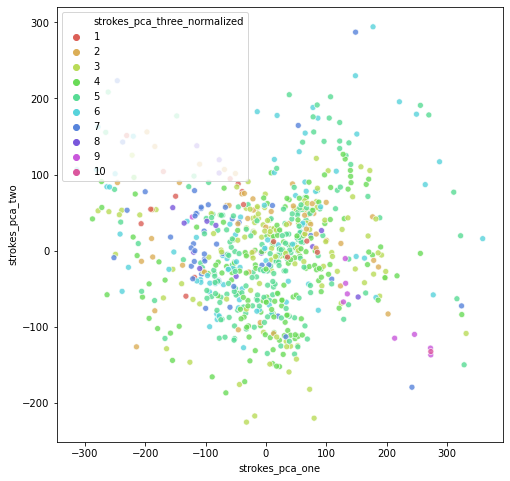

In [22]:
plt.figure(figsize=(8,8))
sns.scatterplot(
        x="strokes_pca_one", y="strokes_pca_two",
        hue="strokes_pca_three_normalized",
        palette=sns.color_palette("hls", 10),
        data = df,
        legend="full",
        alpha=0.8
    )

In [23]:
def plot_like_a_pro(data):
    # setting the colors for the plot
    colors = copy.deepcopy(data[:,2])
    colors -= np.min(colors)
    colors /= np.max(np.abs(colors),axis=0)
    colors *= 10
    colors = colors.astype(int)
    number_of_colors = np.max(colors)-np.min(colors)

    # setting the plot
    plt.figure(figsize=(8,5))
    _= sns.scatterplot(
            x=data[:,0], y=data[:,1],
            hue= colors,
            palette=sns.color_palette("hls", number_of_colors+1),
            #data = df,
            legend="full",
            alpha=1
        )

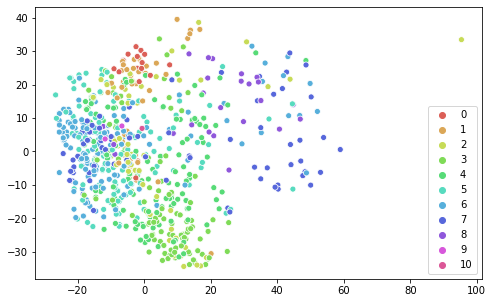

In [24]:
pca_strokes = PCA(n_components= 3)
pca_result_strokes = pca_strokes.fit_transform(strokes_2d)
plot_like_a_pro(pca_result_strokes)

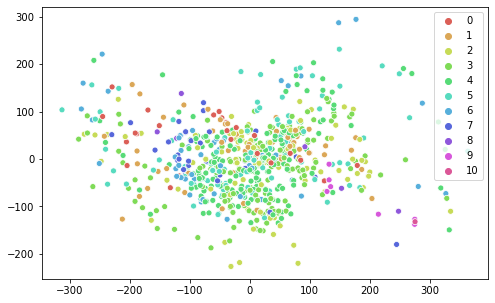

In [25]:
pca_motions = PCA(n_components= 3)
pca_result_motions = pca_motions.fit_transform(motions_2d)
plot_like_a_pro(pca_result_motions)

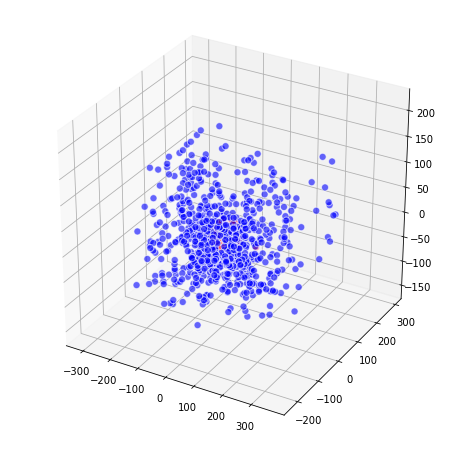

In [26]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pca_result_motions[:,0]
ys = pca_result_motions[:,1]
zs = pca_result_motions[:,2]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w', c = 'b')

xs = pca_result_strokes[:,0]
ys = pca_result_strokes[:,1]
zs = pca_result_strokes[:,2]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w', c = 'r')

plt.show()

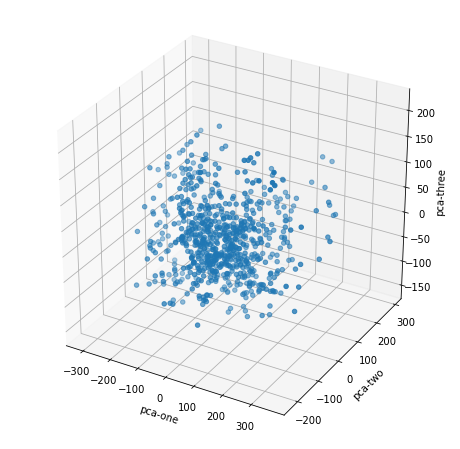

In [27]:
ax = plt.figure(figsize=(8,8)).gca(projection='3d')
ax.scatter(
    xs = pca_result_motions[:,0],
    ys = pca_result_motions[:,1],
    zs = pca_result_motions[:,2] ,
    #c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### T-SNE

In [28]:
def plot_like_a_pro_no_color(data):
    # setting the colors for the plot
    colors = copy.deepcopy(data[:,2])
    colors -= np.min(colors)
    colors /= np.max(np.abs(colors),axis=0)
    colors *= 10
    colors = colors.astype(int)
    number_of_colors = np.max(colors)-np.min(colors)

    # setting the plot
    plt.figure(figsize=(8,5))
    _= sns.scatterplot(
            x=data[:,0], y=data[:,1],
            #hue= colors,
            palette=sns.color_palette("hls", number_of_colors+1),
            #data = df,
            legend="full",
            alpha=1
        )

In [29]:
tsne_motions = TSNE(n_components = 3, verbose = 1, perplexity=40, n_iter=300)
tsne_motions_results = tsne_motions.fit_transform(motions_2d)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.033s...
[t-SNE] Computed neighbors for 719 samples in 0.275s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 32.602179
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.518089
[t-SNE] KL divergence after 300 iterations: 1.459058


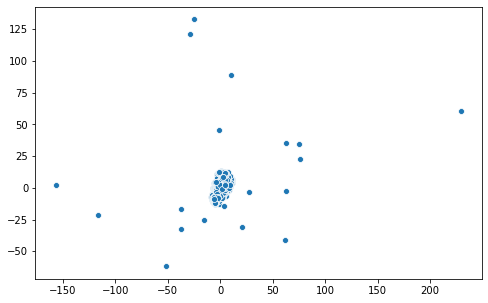

In [30]:
plot_like_a_pro_no_color(tsne_motions_results)

In [31]:
tsne_strokes = TSNE(n_components = 3, verbose = 1, perplexity=40, n_iter=300)
tsne_strokes_results = tsne_strokes.fit_transform(strokes_2d)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 6.062s...
[t-SNE] Computed neighbors for 719 samples in 32.103s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 10.966839
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.189293
[t-SNE] KL divergence after 300 iterations: 1.907544


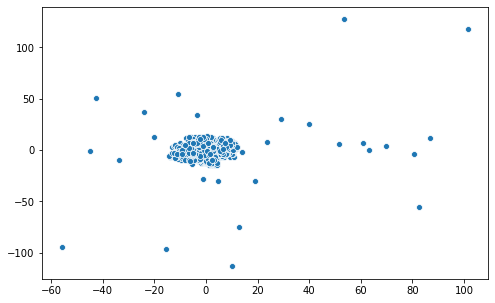

In [32]:
plot_like_a_pro_no_color(tsne_strokes_results)

In [33]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_motions = scaler.fit(motions_2d)
scaled_motion_data_ = scaled_motions.transform(motions_2d)
scaled_motion_data = np.reshape(scaled_motion_data_, dataSet.Y_motions.shape)

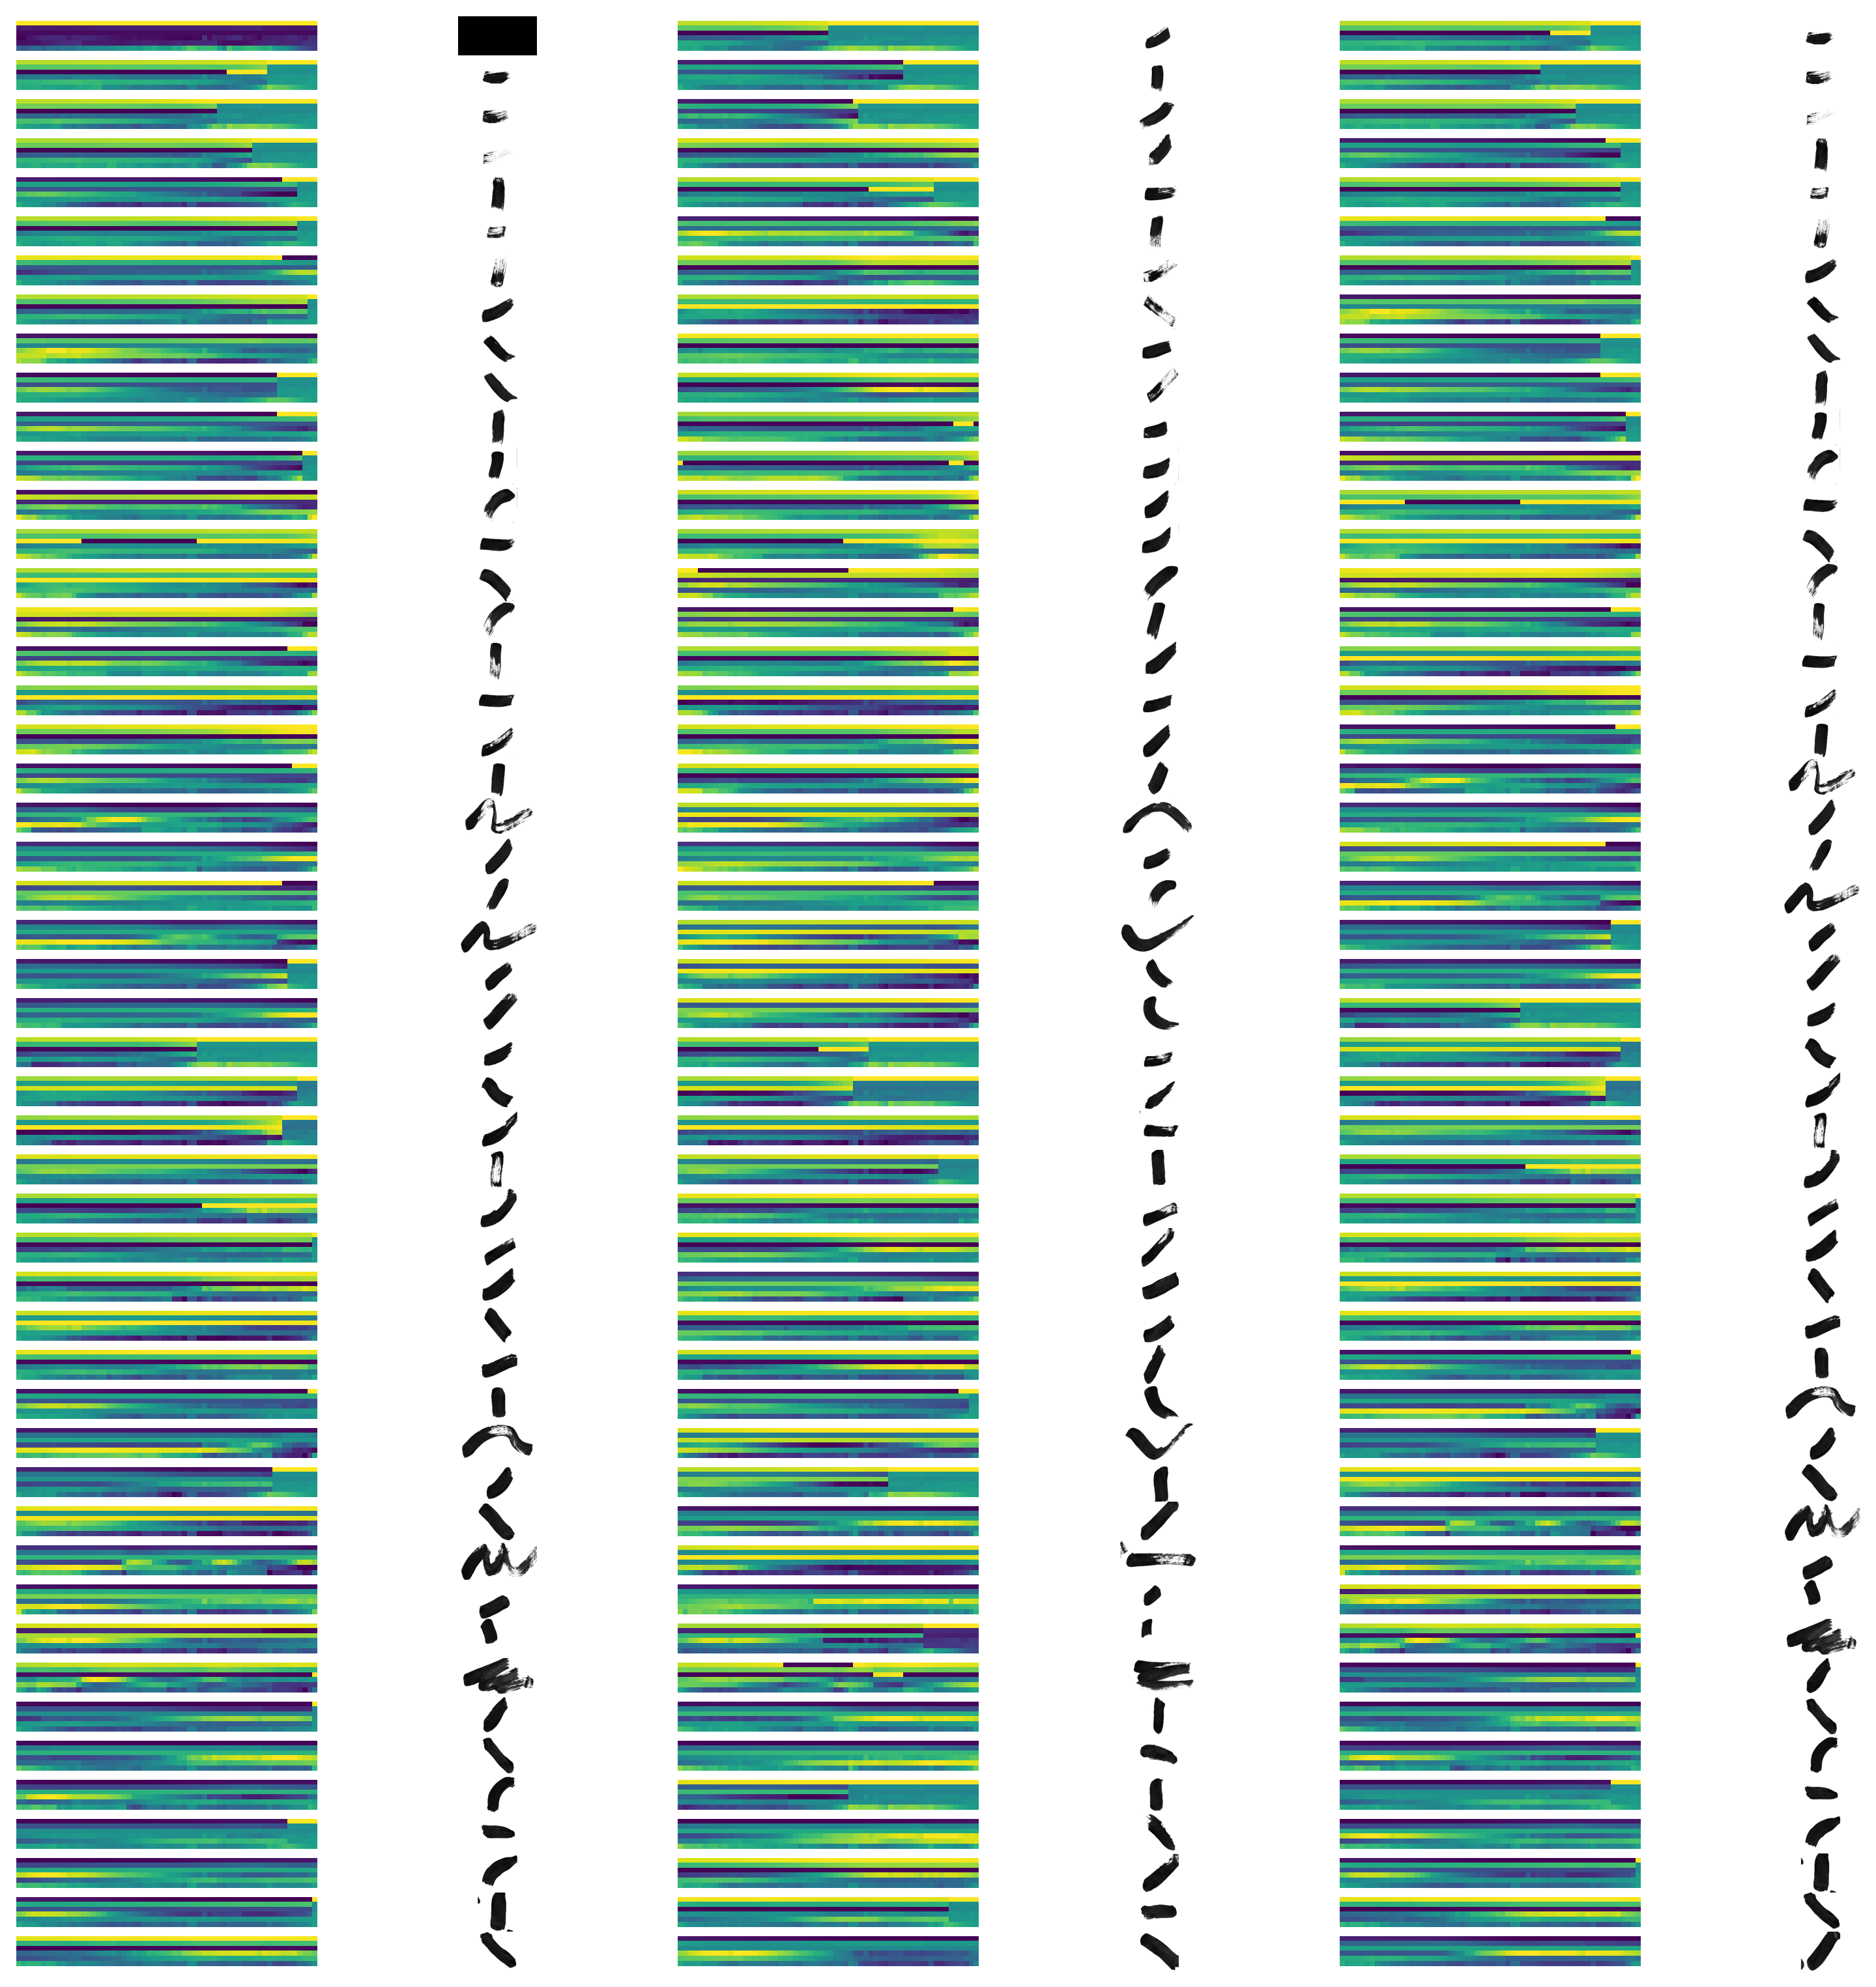

In [34]:
number_of_rows = 50
number_of_cols = 3
fig, axes = plt.subplots(number_of_rows, number_of_cols*2, figsize=(12,12),  dpi=250)

for j in range(number_of_rows):
    for i in range (number_of_cols):
        ax = axes[j][i*2]
        ax.axis("off")
        ax.imshow(scaled_motion_data[j*2+i].T)        
        ax = axes[j][i*2+1]
        ax.axis("off")
        ax.imshow(dataSet.X_stroeks[j*2+i],cmap = 'gray')
        
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

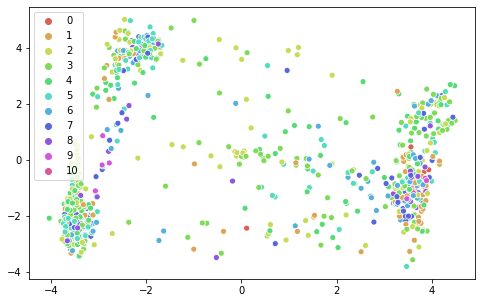

In [35]:
pca_motions = PCA(n_components= 3)
pca_result_motions = pca_motions.fit_transform(scaled_motion_data_)
plot_like_a_pro(pca_result_motions)

In [40]:
import plotly.graph_objects as go

In [42]:
np.random.seed(1)

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


scatter.on_click(update_point)

In [ ]:
print (numpy.__version__)